In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Optimizer, Adam, SGD
from torchvision import transforms, datasets
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

###  Загрузка и преобразование датасета

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_dir = '/home/victor/Datasets/Data-Science/mushrooms'
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
num_classes = len(dataset.classes)

print(f"size: {len(dataset)}\nnum classes: {num_classes}\nclasses: {dataset.classes}")

size: 6714
num classes: 9
classes: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [3]:
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

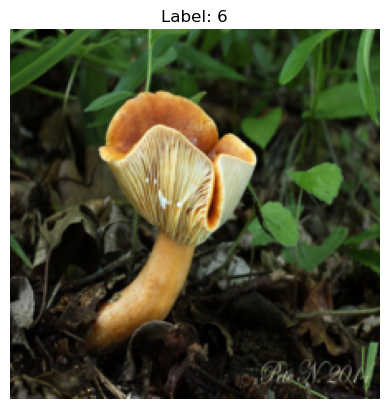

In [4]:
def denormalize_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

data_iter = iter(train_loader)
images, labels = next(data_iter)

image = images[0]
label = labels[0]

image = denormalize_image(image).permute(1, 2, 0).numpy()

plt.imshow(np.clip(image, 0, 1)) 
plt.title(f"Label: {label.item()}")
plt.axis("off")
plt.show()

функция для тренировки

In [5]:
def train(net: torch.nn.Module,
          train_loader: DataLoader,
          optimizer :Optimizer,
          num_epochs: int,
          device: str = 'cuda') -> list:
    
    torch.cuda.empty_cache()
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = loss_function(outputs, labels)
              
                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [6]:
def print_history(history: list, title: str = "CNN Accurancy"):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

Функция для inference и расчета accurancy 

In [7]:
def evaluate_acc(net: nn.Module,
                 test_loader: DataLoader,
                 device: str = 'cuda'):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    print(f"accurancy: {acc}")

### Обучение собственной CNN

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(512*3*3, 128),
            nn.Dropout(0.1),
            nn.Tanh()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(128, num_classes),
            nn.Dropout(0.1),
            nn.Softmax(dim=1)
        )
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        return x

In [9]:
NUM_EPOCHS = 50
LR = 0.01

net = CustomCNN(num_classes=num_classes).to(device)
optimizer = SGD(net.parameters(), lr=LR)

print_history(train(net, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(net, test_loader)

Epoch: 2, Batch: 50, Loss: 111.85, Acc: 0.22:   5%|▍         | 387/8400 [02:37<54:24,  2.45it/s] 


KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 50
LR = 0.01

net = CustomCNN(num_classes=num_classes).to(device)
optimizer = Adam(net.parameters(), lr=LR)

print_history(train(net, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(net, test_loader)

Epoch: 39, Batch: 43, Loss: 94.53, Acc: 0.22:  79%|███████▊  | 6596/8400 [25:06<08:14,  3.65it/s]  

### Использование Resnet18

In [ ]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

for param in resnet.fc.parameters():
    param.requires_grad = True
    
resnet = resnet.to(device)

/home/victor/Study/University/Data Science/CNN/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/Study/University/Data Science/CNN/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 9, Batch: 671, Loss: 607.90, Acc: 0.33: 100%|██████████| 6720/6720 [05:59<00:00, 18.72it/s]


accurancy: 0.5830230826507818


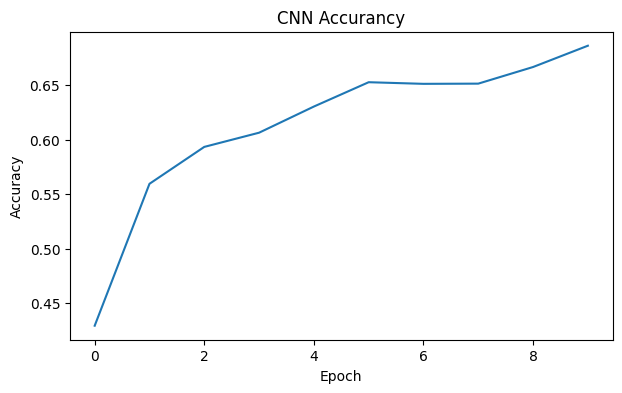

In [ ]:
NUM_EPOCHS = 50
LR = 0.01
optimizer = SGD(resnet.parameters(), lr=LR)

print_history(train(resnet, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(resnet, test_loader)

Epoch: 9, Batch: 671, Loss: 1200.62, Acc: 0.00: 100%|██████████| 6720/6720 [06:00<00:00, 18.66it/s]


accurancy: 0.36932241250930753


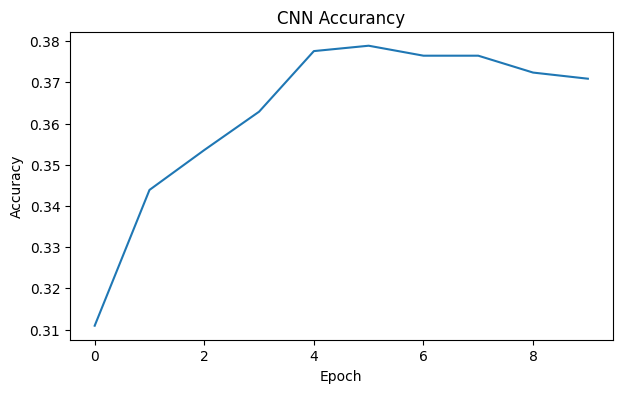

In [ ]:
NUM_EPOCHS = 50
LR = 0.01
optimizer = Adam(resnet.parameters(), lr=LR)

print_history(train(resnet, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(resnet, test_loader)

**Вывод:** Лучше всего использовать Resnet18 с оптимизаторов SGD